In [ ]:
#Find date format 
#**Please note this file uses false filepaths/keys for public consumption, Therefore attmepting to re-run this code will return an error.
future_ex_vars_df = pd.read_csv('data.csv')
print("Sample date format:", df['ds'].iloc[0])

Sample date format: 6/28/21


In [ ]:
# Read the data
df = pd.read_csv('data.csv')

# Fill all empty cells (NaN) with 0
df = df.fillna(0)

# Anomaly detection using a 70% confidence interval
anomalies_df = nixtlaClient.detect_anomalies(
    df, 
    freq='D',
    level=70
)

# Plot anomalies
nixtlaClient.plot(df, anomalies_df)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['aht', 'abn', 'asa', 'forecast']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


          ds    TimeGPT  TimeGPT-hi-90  TimeGPT-lo-90
0 2024-04-29  120.91138      278.86227      -37.03952
1 2024-04-30  387.94147      531.44104      244.44193
2 2024-05-01  504.52618      675.28200      333.77040
3 2024-05-02  455.78590      603.19820      308.37360
4 2024-05-03  453.34875      547.34090      359.35663


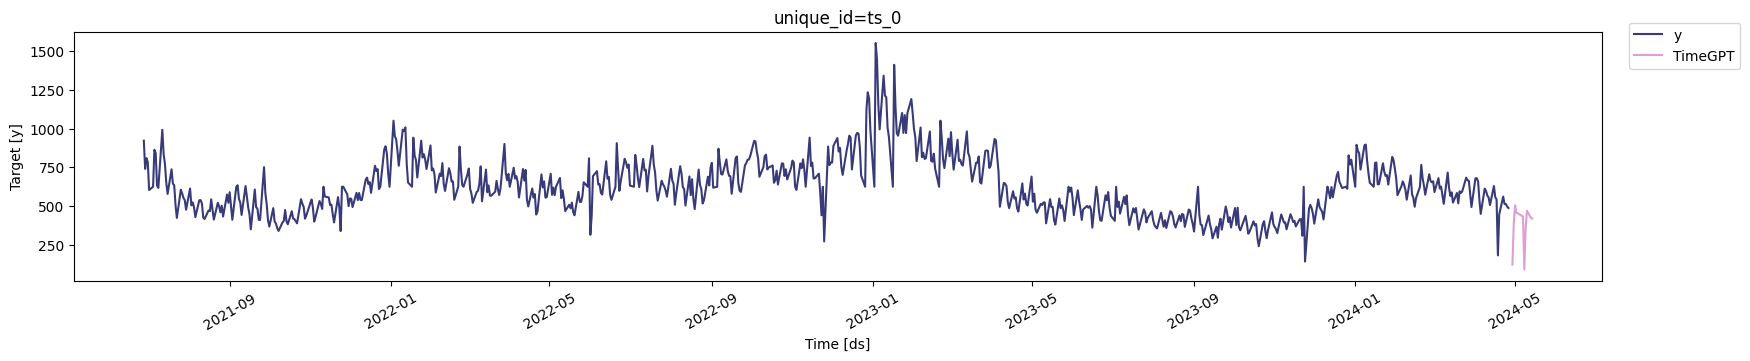

In [ ]:
#import standard objects
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from utilsforecast.losses import mae
from nixtla import NixtlaClient

#Initaite / Authorize api call
nixtlaClient = NixtlaClient (
    api_key = 'dauickh884762jicoaucjiliuqnilahuioqei876vnbzc'
)
nixtlaClient.validate_api_key()

# Step 1: read data
df = pd.read_csv('data.csv')
# Step 2: Rename columns
df.rename(columns={'date': 'ds', 'actual': 'y'}, inplace=True)

# Step 4: Ensure the future exogenous variable DataFrame matches the historical one
future_ex_vars_df = df.drop(columns=['y'])

# Trim `future_ex_vars_df` to match the horizon (`h`)
h = 12  # Set the forecast horizon
future_ex_vars_df = future_ex_vars_df.iloc[-h:]  # Keep only the last `h` rows

# Ensure datetime columns are properly formatted
df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%y')
future_ex_vars_df['ds'] = pd.to_datetime(future_ex_vars_df['ds'], format='%m/%d/%y')

hist_cols = ["aht", "abn", "asa", "forecast"]
future_ex_vars_df_limited = future_ex_vars_df.drop(columns=hist_cols)

# Sort by date and remove any duplicate timestamps
df = df.sort_values('ds').drop_duplicates('ds')
future_ex_vars_df = future_ex_vars_df.sort_values('ds').drop_duplicates('ds')

# Ensure business day frequency is consistent
df = df.set_index('ds').asfreq('B').reset_index()
future_ex_vars_df = future_ex_vars_df.set_index('ds').asfreq('B').reset_index()

# Fill NaN values only in the main dataframe
df['y'] = df['y'].fillna(df['y'].mean())

# For future_ex_vars_df, only fill NaN in the exogenous variables
numeric_columns_future = future_ex_vars_df.select_dtypes(include=[np.number]).columns
future_ex_vars_df[numeric_columns_future] = future_ex_vars_df[numeric_columns_future].fillna(future_ex_vars_df[numeric_columns_future].mean())

# Step 7: Perform the forecast
timegpt_fcst_ex_vars_df = nixtlaClient.forecast(
    df=df,
    h=12,
    freq='B',
    level=[90],
    finetune_steps=10,
    hist_exog_list=hist_cols,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

# Step 8: Display the forecasted data
print(timegpt_fcst_ex_vars_df.head())

nixtlaClient.plot(df, timegpt_fcst_ex_vars_df, time_col='ds', target_col='y')